# DATA CLEANING, TRANSFORMATION & EXPLORATORY


In [1]:
#Libraries used for the CLEANING, TRANSFORMATION AND EXPLORATORY analylis of the data

import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sbn
from pandas.plotting import lag_plot
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline




Opening the file of the Air indexes and the file of the weather metrics to verify the completness and correctness of the data

## 2.1 AIR QUALITY MEASUREMENT REFERENCE FILE


### 2.1.1 AIR QUALITY DATA DICTIONARY

Data is gather in real time by different stations locations across several areas in Madrid city. Data is storage in multiple files, but they were consolidated in only one reference file. (This is explained in notebook "1a_Extract_Concat_AirQ_measurements.ipynb")
 The study will use ".csv", which follow this data structure

PROVINCIA | MUNICIPIO | ESTACION | MAGNITUD | PUNTO DE MUESTREO | AÑO | MES | DIA | Hxx (dato horario) | Vxx (código de validacion)
:--------: | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- 
28 | 079 | 004 | 01 | 28079004_1_38| 17 |07 | 01| 00005 | V 


**PROVINCIA.** Spanish province where the study is located. 28 belongs to Madrid

**MUNICIPIO.** Municipality where the study is located. 079 belongs to Madrid city

**ESTACION.** Measuring station. In Madrid there are 24 stations across all the districts.

**MAGNITUD.** Every station measure different parameters related to air quality. __This study will only need Magnitud related to Monoxido de Nitrogeno, NO2 that is represented as Magnitud = "08".__ This is expressed in µg/m^3

**PUNTO DE MUESTREO.** This is a code including the station id (including provincia, municipio y estacion), and adding the "magnitud" and "tecnica de muestreo".

**Hxx (dato horario).** Data value per hour.

**Vxx (codigo de validacion).** Flag to identify the valid measurements, filtering out others that may have some issue during the measurement process. So, __the only valid values have a "V" in this field.__

**H01/VO1, H02/V02.** There are 48 extra columns related to hour (H01 = 1:00 am, H02 = 2:00 am..) and validation (V01 = data flag related to the data aat 1:00 am...). NOTE. For practical reason in the analyis the representation of the hours have been modified 1 second, just to allow reference the H24 to the same date. This is just matter of data representation not altering any result in the analysis.

### 2.1.2 DATA CLEANING AND TRANSFORMATION

In [2]:
#Creating dataframe with all data from the reference AirQuality file.

air_index = pd.read_csv ("../data/interim/AirQuality/ref_air_quality.csv", sep= ',')

In [3]:
air_index.head()


,Unnamed: 0,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,...,V20,H21,V21,H22,V22,H23,V23,H24,V24,source_file
0,0,28,79,4,1,28079004_1_38,2019,4,1,4.0,...,V,2.0,V,4.0,V,4.0,V,4.0,V,abr_mo19.csv
1,1,28,79,4,1,28079004_1_38,2019,4,2,3.0,...,V,4.0,V,4.0,V,4.0,V,4.0,V,abr_mo19.csv
2,2,28,79,4,1,28079004_1_38,2019,4,3,3.0,...,V,5.0,V,5.0,V,5.0,V,4.0,V,abr_mo19.csv
3,3,28,79,4,1,28079004_1_38,2019,4,4,4.0,...,V,4.0,V,4.0,V,3.0,V,4.0,V,abr_mo19.csv
4,4,28,79,4,1,28079004_1_38,2019,4,5,4.0,...,V,2.0,V,2.0,V,1.0,V,1.0,V,abr_mo19.csv


**2.1.2.1 Checking empty values in the different fields and rows**

In [4]:
air_index.isnull().sum()

Unnamed: 0        0
PROVINCIA         0
MUNICIPIO         0
ESTACION          0
MAGNITUD          0
PUNTO_MUESTREO    0
ANO               0
MES               0
DIA               0
H01               0
V01               0
H02               0
V02               0
H03               0
V03               0
H04               0
V04               0
H05               0
V05               0
H06               0
V06               0
H07               0
V07               0
H08               0
V08               0
H09               0
V09               0
H10               0
V10               0
H11               0
V11               0
H12               0
V12               0
H13               0
V13               0
H14               0
V14               0
H15               0
V15               0
H16               0
V16               0
H17               0
V17               0
H18               0
V18               0
H19               0
V19               0
H20               0
V20               0
H21               0


**Conclusion: No empty fields in the data**

**2.1.2.2 Analysis of Data validity field**

"Vxx" fields can contain N, what means that value related to that hour is not valid. So, as part of the cleaning and data transformation a deeper analysis will be needed to take a decision about the relevance of those values and impact in the final predicion, just to decide to clean this data from all stations or not.

In [4]:
#Checking volumes of not valid measurements(with N in Vxx fields)
air_index_matrix= air_index[['V01','V02','V03','V04','V05','V06','V07','V08','V09','V10','V11','V12','V13','V14', 'V15','V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24']].apply(pd.Series.value_counts)

In [5]:
air_index_transpose = air_index_matrix.transpose()
air_index_transpose

,V,N
V01,141745,1231
V02,141725,1251
V03,141313,1663
V04,141728,1248
V05,141694,1282
V06,141675,1301
V07,141604,1372
V08,141402,1574
V09,140833,2143
V10,139949,3027


In [6]:
air_index_transpose.sum()

V    3382952
N      48472
dtype: int64

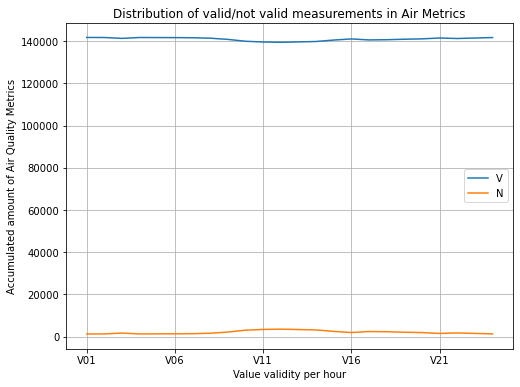

In [7]:
air_index_transpose.plot(figsize=(8,6))
plt.ylabel("Accumulated amount of Air Quality Metrics");
plt.xlabel("Value validity per hour");
plt.title("Distribution of valid/not valid measurements in Air Metrics");
plt.grid(True);

**Conclusion: Not valid values are less than 1%, so the potential impact in the models should not be relevant. During next iterations this will be re-evaluated**

**2.1.2.3 Data Transformation**

The scope of the study is only based on NO2 index, so the values related to ther indexes in the field "MAGNITUD" should be ignored (not only in the POC, from full study)

In [11]:
#Selecting only NO2 metric
air_index8 = air_index[(air_index['MAGNITUD'] == 8)]

The current data structure is not optimal for the analyis, so different transformation steps are going to be done.

1. Creation of TimeStamp just looking to simplify the data structure to something better to read. This is done with the function "to_datetime", concatenating the 3 fields in the original data in a date.https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html

In [10]:
# Creation of a "DATE" field with the concatenation of ANO, MES & DIA
air_index8 ['DATE'] = pd.to_datetime({'year': air_index8['ANO'],
                                                          'month': air_index8['MES'],
                                                          'day': air_index8['DIA']})

<ipython-input-10-3479c0d76be1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air_index8 ['DATE'] = pd.to_datetime({'year': air_index8['ANO'],


2. Hour information is storage in multiple columns, one per hour. This is not practical to manage the dataset, so a second transformation step has been done using "wide to long" concept, using "melt" function from pandas. This function is useful to massage a DataFrame into a format where one or more columns are identifier variables (id_vars), while all other columns, considered measured variables (value_vars), are “unpivoted” to the row axis, leaving just two non-identifier columns, ‘variable’ and ‘value’
https://pandas.pydata.org/docs/reference/api/pandas.melt.html#pandas.melt

In [11]:
# Dataframe transformation, keeping needed data and creating measured variables originally in columns

air_index8 = pd.melt(air_index8, id_vars=['ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO','DATE'], value_vars=['H01', 'H02', 'H03', 'H04', 'H05',
                                                                                                'H06', 'H07', 'H08', 'H09', 'H10',
                                                                                                'H11', 'H12', 'H13', 'H14', 'H15',
                                                                                                'H16', 'H17', 'H18', 'H19', 'H20',
                                                                                                'H21', 'H22', 'H23', 'H24'])

3. Stil data require some other transformation to allow us manipulate and visualize it properly, it requires to transform the "variables" from columns created with melt function together with the date to create a Timestamp field, what will facilitate us the data manipulation.

In [12]:
#Creation of HOUR field based on the hourly columns manipulated with melt funcion and now storage in "variable" field
air_index8['HOUR'] = [int(x[1:3]) for x in air_index8.variable.values]

4. Creation of Timestamp and indexing

In [13]:
#Creation of timestamp field & indexing time
air_index8['TIME'] = air_index8['DATE'].astype(str) + ' ' + (air_index8['HOUR']-1).astype(str) + ':59:59'
air_index8['TIME']=pd.to_datetime(air_index8['TIME'] )
air_index8.index = air_index8.TIME

5. Cleaning not needed columns and rename other columns to more intuitive name.

ESTACION = AIR_STATION_ID. Air Measuring station id. In Madrid there are 24 stations across all the districts.

PUNTO_MUESTREO = AIR_METRIC_POINT. This is a code including the Air Station id (including provincia, municipio y estacion), and adding the "magnitud" and "tecnica de muestreo"

In [14]:
#Cleaning dataframe
air_index8.rename(columns={'value':'NO2_index'},inplace=True)
air_index8.rename(columns={'ESTACION':'AirStationId'},inplace=True)
air_index8.drop(['variable'], axis = 'columns', inplace=True)
air_index8.drop(['MAGNITUD'], axis = 'columns', inplace=True)
air_index8.drop(['PUNTO_MUESTREO'], axis = 'columns', inplace=True)

In [15]:
air_index8

,AirStationId,DATE,NO2_index,HOUR,TIME
TIME,,,,,
2019-04-01 00:59:59,4,2019-04-01,17.0,1,2019-04-01 00:59:59
2019-04-02 00:59:59,4,2019-04-02,22.0,1,2019-04-02 00:59:59
2019-04-03 00:59:59,4,2019-04-03,33.0,1,2019-04-03 00:59:59
2019-04-04 00:59:59,4,2019-04-04,20.0,1,2019-04-04 00:59:59
2019-04-05 00:59:59,4,2019-04-05,22.0,1,2019-04-05 00:59:59
...,...,...,...,...,...
2021-06-26 23:59:59,60,2021-06-26,25.0,24,2021-06-26 23:59:59
2021-06-27 23:59:59,60,2021-06-27,14.0,24,2021-06-27 23:59:59
2021-06-28 23:59:59,60,2021-06-28,18.0,24,2021-06-28 23:59:59


**2.1.2.4 TRANSFORMATION AIR QUALITY DATA - CODE SUMMARY**

In [4]:
#Selecting only NO2 metric
air_index8 = air_index[(air_index['MAGNITUD'] == 8)]

#Creation of a "DATE" field with the concatenation of ANO, MES & DIA
air_index8 ['DATE'] = pd.to_datetime({'year': air_index8['ANO'],
                                                          'month': air_index8['MES'],
                                                          'day': air_index8['DIA']})

#Dataframe transformation, keeping the needed data and creating measured variables originally in columns
air_index8 = pd.melt(air_index8, id_vars=['ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO','DATE'], value_vars=['H01', 'H02', 'H03', 'H04', 'H05',
                                                                                                'H06', 'H07', 'H08', 'H09', 'H10',
                                                                                                'H11', 'H12', 'H13', 'H14', 'H15',
                                                                                                'H16', 'H17', 'H18', 'H19', 'H20',
                                                                                                'H21', 'H22', 'H23', 'H24'])

#Creation of HORA field based on the hourly columns manipulated with melt funcion and now storage in "variable" field
air_index8['HOUR'] = [int(x[1:3]) for x in air_index8.variable.values]

#Creation of timestamp field & indexing time
air_index8['TIME'] = air_index8['DATE'].astype(str) + ' ' + (air_index8['HOUR']-1).astype(str) + ':59:59'
air_index8['TIME']=pd.to_datetime(air_index8['TIME'] )
air_index8.index = air_index8.TIME

#Cleaning dataframe
air_index8.rename(columns={'value':'NO2_index'},inplace=True)
air_index8.rename(columns={'ESTACION':'AirStationId'},inplace=True)
air_index8.drop(['variable'], axis = 'columns', inplace=True)
air_index8.drop(['MAGNITUD'], axis = 'columns', inplace=True)
air_index8.drop(['PUNTO_MUESTREO'], axis = 'columns', inplace=True)


<ipython-input-4-0a277fd91ab7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air_index8 ['DATE'] = pd.to_datetime({'year': air_index8['ANO'],


In [5]:
air_index8.head()

,AirStationId,DATE,NO2_index,HOUR,TIME
TIME,,,,,
2019-04-01 00:59:59,4,2019-04-01,17.0,1,2019-04-01 00:59:59
2019-04-02 00:59:59,4,2019-04-02,22.0,1,2019-04-02 00:59:59
2019-04-03 00:59:59,4,2019-04-03,33.0,1,2019-04-03 00:59:59
2019-04-04 00:59:59,4,2019-04-04,20.0,1,2019-04-04 00:59:59
2019-04-05 00:59:59,4,2019-04-05,22.0,1,2019-04-05 00:59:59


### 2.1.3 DATA EXPLORATORY

In this step, analysis of the data will be done to start knowing the data, the gaps, anomalyies, trends..., Although the most relevant exploratory analysis will come as soon air quality and weather conditions are merged.

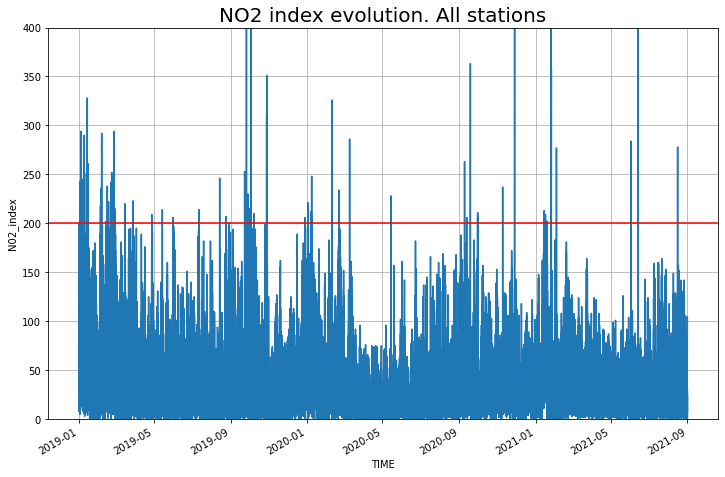

In [11]:
# Plotting  N02 index evolution
plot = air_index8['NO2_index'].plot(figsize=(12, 8))
plt.ylim(0,400)
plt.ylabel("N02_index", fontsize=10)
plt.xlabel("TIME", fontsize=10)
plt.title ("NO2 index evolution. All stations", fontsize=20)
plt.grid()
plt.axhline(y=200, c='r')

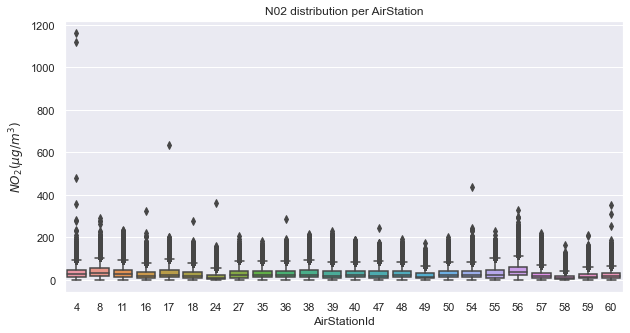

In [12]:
# N02 distribution per AirStation
sbn.set(rc={'figure.figsize':(10, 5)})
sbn.boxplot(data=air_index8, x='AirStationId', y='NO2_index').set(title="N02 distribution per AirStation", ylabel='$NO_2 (µg/m^3)$');

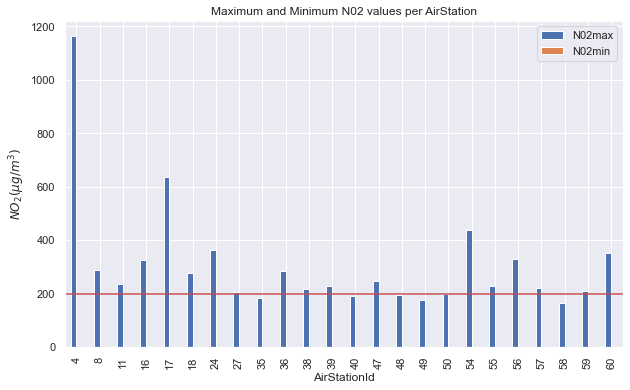

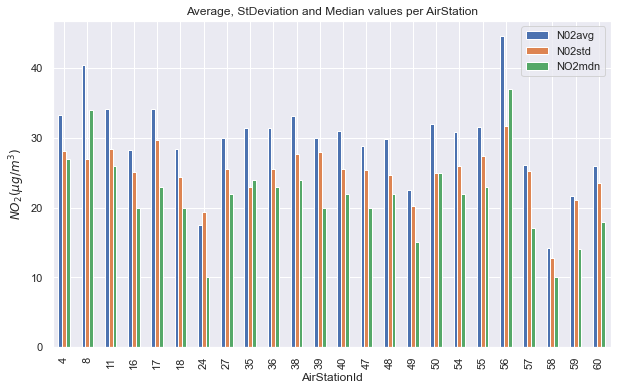

In [26]:
air_index8.groupby("AirStationId").agg(N02max =('NO2_index', 'max'),N02min =('NO2_index', 'min')).plot(kind='bar',figsize=(10, 6))
plt.ylabel("$NO_2 (µg/m^3)$");
plt.title("Maximum and Minimum N02 values per AirStation")
plt.grid(True)
plt.axhline(y=200, c='r')
air_index8.groupby("AirStationId").agg(N02avg = ('NO2_index', 'mean'),
                                        N02std =('NO2_index', 'std'), NO2mdn = ("NO2_index", "median")).plot(kind="bar",figsize=(10, 6))
plt.ylabel("$NO_2 (µg/m^3)$");
plt.title("Average, StDeviation and Median values per AirStation")
plt.grid(True)


**Conclusion1: The station id 56 has the higher N02 avg & std values, and the second station is StationId 8, being the stations with lower values the station 24 and 58. And there are some outliers values in station 4 and 17.. a part of other not so clear in other stations**

In [38]:
air_index8.groupby([air_index8['TIME'].dt.weekday, "AirStationId"])["NO2_index"].mean()

TIME  AirStationId
0     4               35.017949
      8               41.816483
      11              35.522482
      16              29.103717
      17              34.668465
                        ...    
6     56              35.092693
      57              20.121103
      58              10.936751
      59              16.784367
      60              20.204736
Name: NO2_index, Length: 168, dtype: float64

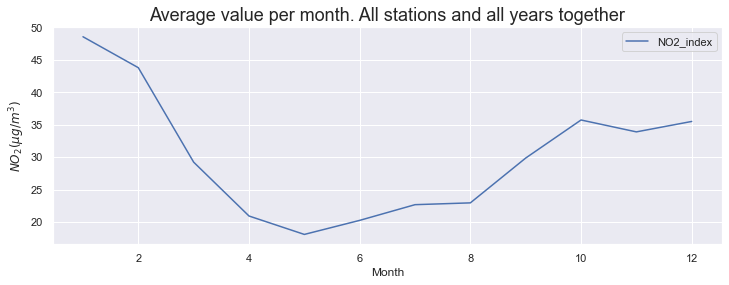

In [70]:
#Average value per month. Pattern of all stations together
mean2019 = air_index8.loc["2019"]
mean2020 = air_index8.loc["2020"]
mean2021 = air_index8.loc["2021"]

fig, axs = plt.subplots(figsize=(12, 4))
air_index8.groupby(air_index8["TIME"].dt.month)["NO2_index"].mean().plot(kind='line', rot=0, ax=axs)
#mean2019.groupby(mean2019["TIME"].dt.hour)["NO2_index"].mean().plot(kind='line', rot=0, ax=axs)
#mean2020.groupby(mean2020["TIME"].dt.hour)["NO2_index"].mean().plot(kind='line', rot=0, ax=axs)
#mean2021.groupby(mean2021["TIME"].dt.hour)["NO2_index"].mean().plot(kind='line', rot=0, ax=axs)
plt.xlabel("Month", fontsize=12);
plt.ylabel("$NO_2 (µg/m^3)$", fontsize=12);
plt.title("Average value per month. All stations and all years together", fontsize=18);
plt.legend();

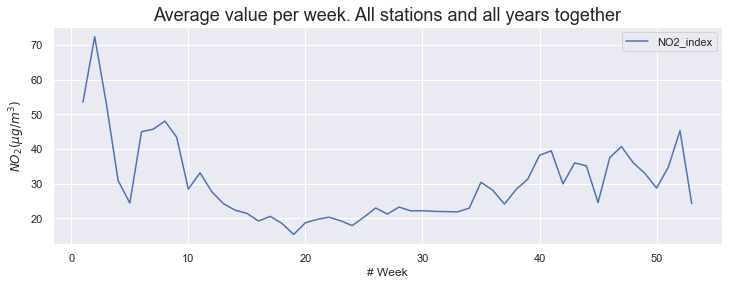

In [68]:
#Average value per week. Pattern of all stations together
mean2019 = air_index8.loc["2019"]
mean2020 = air_index8.loc["2020"]
mean2021 = air_index8.loc["2021"]

fig, axs = plt.subplots(figsize=(12, 4))
air_index8.groupby(air_index8["TIME"].dt.isocalendar().week)["NO2_index"].mean().plot(kind='line', rot=0, ax=axs)
#mean2019.groupby(mean2019["TIME"].dt.hour)["NO2_index"].mean().plot(kind='line', rot=0, ax=axs)
#mean2020.groupby(mean2020["TIME"].dt.hour)["NO2_index"].mean().plot(kind='line', rot=0, ax=axs)
#mean2021.groupby(mean2021["TIME"].dt.hour)["NO2_index"].mean().plot(kind='line', rot=0, ax=axs)
plt.xlabel("# Week", fontsize=12);
plt.ylabel("$NO_2 (µg/m^3)$", fontsize=12);
plt.title("Average value per week. All stations and all years together", fontsize=18);
plt.legend();

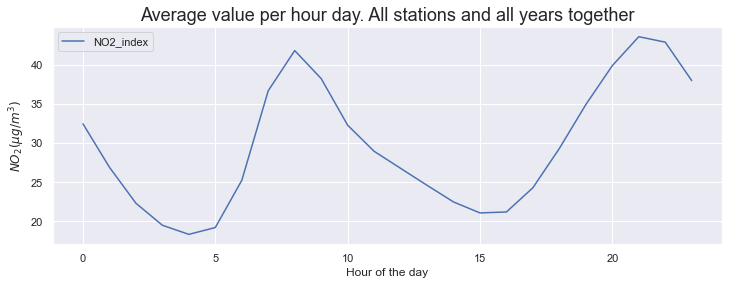

In [69]:
#Average value per hour day. Pattern of all stations together
mean2019 = air_index8.loc["2019"]
mean2020 = air_index8.loc["2020"]
mean2021 = air_index8.loc["2021"]

fig, axs = plt.subplots(figsize=(12, 4))
air_index8.groupby(air_index8["TIME"].dt.hour)["NO2_index"].mean().plot(kind='line', rot=0, ax=axs)
#mean2019.groupby(mean2019["TIME"].dt.hour)["NO2_index"].mean().plot(kind='line', rot=0, ax=axs)
#mean2020.groupby(mean2020["TIME"].dt.hour)["NO2_index"].mean().plot(kind='line', rot=0, ax=axs)
#mean2021.groupby(mean2021["TIME"].dt.hour)["NO2_index"].mean().plot(kind='line', rot=0, ax=axs)
plt.xlabel("Hour of the day", fontsize=12);
plt.ylabel("$NO_2 (µg/m^3)$", fontsize=12);
plt.title("Average value per hour day. All stations and all years together", fontsize=18);
plt.legend()


**Conclusion2: There are two clear pollution peaks in the day; the values at 8:00 am and at 21:00 pm are the higher NO2 values**

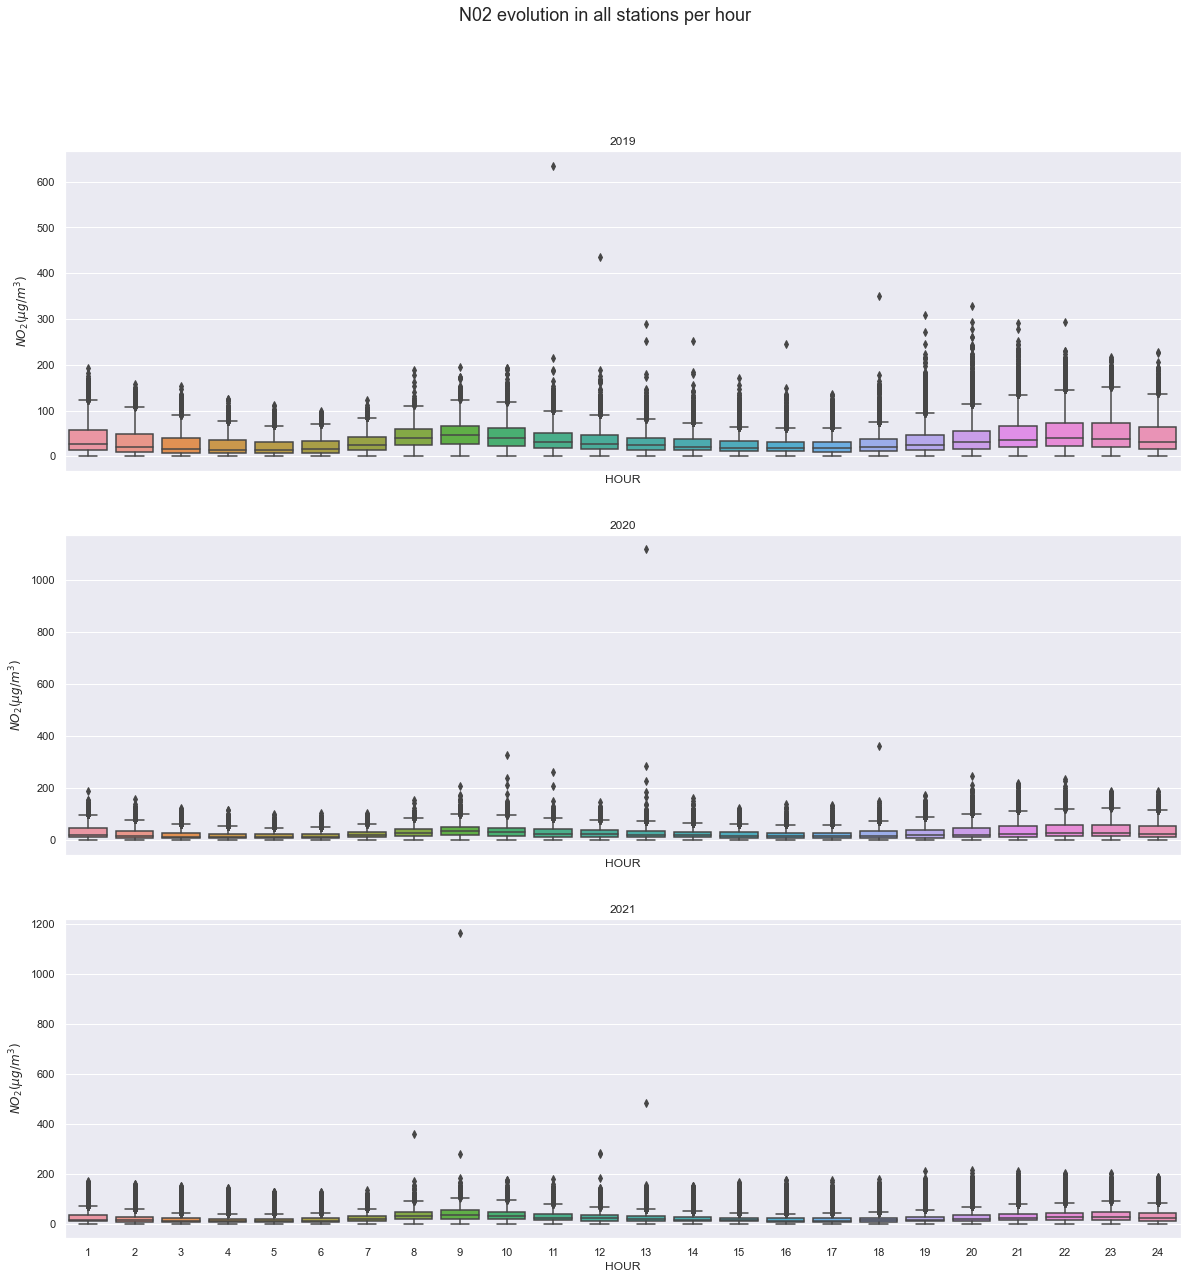

In [38]:
fig, axes = plt.subplots(3, 1,sharex=True)
sbn.set(rc={'figure.figsize':(20, 20)})
fig.suptitle("N02 evolution in all stations per hour", fontsize=18)
sbn.boxplot(ax=axes[0],data=air_index8.loc['2019'], x='HOUR', y='NO2_index').set(title= "2019",ylabel='$NO_2 (µg/m^3)$')
sbn.boxplot(ax=axes[1],data=air_index8.loc['2020'], x='HOUR', y='NO2_index').set(title= "2020",ylabel='$NO_2 (µg/m^3)$')
sbn.boxplot(ax=axes[2],data=air_index8.loc['2021'], x='HOUR', y='NO2_index').set(title= "2021",ylabel='$NO_2 (µg/m^3)$');

## 2.2 WEATHER MEASUREMENTS REFERENCE FILE

### 2.1.1 WEATHER DATA DICTIONARY

Data is gather in real time by different stations locations across several areas in Madrid city. Data is storage in multiple files, but they were consolidated in only one reference file. (This is explained in notebook "1b_Extract_Concat_Weather_measurement.ipynb").

 The study will use ".csv", which follow this data structure (similar to the AirQuality reference file)

PROVINCIA | MUNICIPIO | ESTACION | MAGNITUD | PUNTO DE MUESTREO | AÑO | MES | DIA | Hxx (dato horario) | Vxx (código de validacion)
:--------: | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- 
28 | 079 | 004 | 01 | 28079004_1_38| 17 |07 | 01| 00005 | V 


**PROVINCIA.** Spanish province where the study is located. 28 belongs to Madrid

**MUNICIPIO.** Municipality where the study is located. 079 belongs to Madrid city

**ESTACION.** Measuring station. In Madrid there are 26 stations across all the districts.Some of them are measuring also AirQuality.

**MAGNITUD.** Every station measure different parameters related to air quality. Below is the list of Magnitud and metric measured:

    80 -> Ultraviolet radiation (MW/m2)
    
    81 -> Wind speed (m/s)
    
    82 -> Wind direction
    
    83 -> Temperature (ºC)
    
    86 -> Humidity (%)
    
    87 -> Barometric pressure (mb)
    
    88 -> Solar radiation (W/m2)
    
    89 -> Water precipitation (l/m2)

**PUNTO DE MUESTREO.** This is a code including the station id (including provincia, municipio y estacion), and adding the "magnitud" and "tecnica de muestreo".

**Hxx (dato horario).** Data value per hour.

**Vxx (codigo de validacion).** Flag to identify the valid measurements, filtering out others that may have some issue during the measurement process. So, __the only valid values have a "V" in this field.__

**H01/VO1, H02/V02.** There are 48 extra columns related to hour (H01 = 1:00 am, H02 = 2:00 am..) and validation (V01 = data flag related to the data aat 1:00 am...). NOTE. For practical reason in the analyis the representation of the hours have been modified 1 second, just to allow reference the H24 to the same date. This is just matter of data representation not altering any result in the analysis.

### 2.2.2 DATA CLEANING AND TRANSFORMATION

In [6]:
#Creating dataframe with all data from the reference Weather file.

weather_index = pd.read_csv ("../data/interim/Weather/ref_weather.csv", sep= ',')
weather_index.head()

,Unnamed: 0,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,...,V20,H21,V21,H22,V22,H23,V23,H24,V24,source_file
0,0,28,79,102,81,28079102_81_98,2021,5,1,0.97,...,V,1.37,V,0.93,V,0.85,V,1.10,V,may_meteo21.csv
1,1,28,79,102,81,28079102_81_98,2021,5,2,2.23,...,V,1.93,V,2.12,V,1.70,V,2.57,V,may_meteo21.csv
2,2,28,79,102,81,28079102_81_98,2021,5,3,2.70,...,V,1.27,V,2.60,V,1.92,V,2.75,V,may_meteo21.csv
3,3,28,79,102,81,28079102_81_98,2021,5,4,2.25,...,V,1.57,V,1.67,V,0.75,V,0.38,V,may_meteo21.csv
4,4,28,79,102,81,28079102_81_98,2021,5,5,1.00,...,V,1.62,V,1.57,V,1.18,V,0.68,V,may_meteo21.csv


**2.2.2.1 Checking empty values in the different fields and rows**

In [28]:
#Checking null values

weather_index.isnull().sum()

Unnamed: 0        0
PROVINCIA         0
MUNICIPIO         0
ESTACION          0
MAGNITUD          0
PUNTO_MUESTREO    0
ANO               0
MES               0
DIA               0
H01               0
V01               0
H02               0
V02               0
H03               0
V03               0
H04               0
V04               0
H05               0
V05               0
H06               0
V06               0
H07               0
V07               0
H08               0
V08               0
H09               0
V09               0
H10               0
V10               0
H11               0
V11               0
H12               0
V12               0
H13               0
V13               0
H14               0
V14               0
H15               0
V15               0
H16               0
V16               0
H17               0
V17               0
H18               0
V18               0
H19               0
V19               0
H20               0
V20               0
H21               0


**CONCLUSION:No Nulls/NaNs values in the raw data, FOR NOW!**

**2.2.2.2 Analysis of Data validity field**

"Vxx" fields can contain N, what means that value related to that hour is not valid. So, as part of the cleaning and data transformation a deeper analysis will be needed to take a decision about the relevance of those values and impact in the final predicion, just to decide to clean this data from all stations or not.

In [11]:
#Checking volumes of not valid measurements (with N in Vxx fields)
weather_index_matrix= weather_index[['V01','V02','V03','V04','V05','V06','V07','V08','V09','V10','V11','V12','V13','V14', 'V15','V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24']].apply(pd.Series.value_counts)

In [12]:
weather_index_transpose = weather_index_matrix.transpose()
weather_index_transpose

,V,N
V01,86977,624
V02,86989,612
V03,86664,937
V04,86894,707
V05,86925,676
V06,86935,666
V07,86938,663
V08,86921,680
V09,86862,739
V10,86624,977


In [13]:
weather_index_transpose.sum()

V    2082480
N      19944
dtype: int64

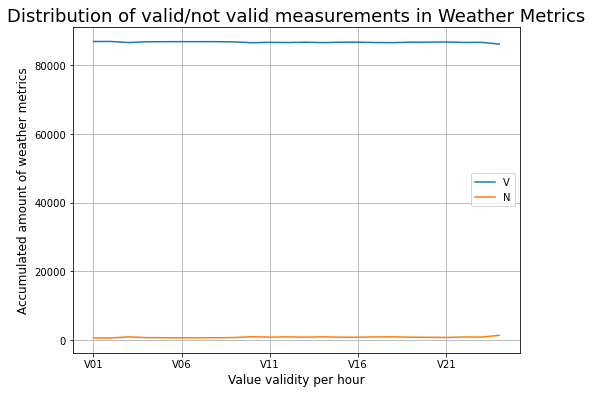

In [14]:
weather_index_transpose.plot(figsize=(8, 6))
plt.ylabel("Accumulated amount of weather metrics",fontsize=12);
plt.xlabel("Value validity per hour", fontsize=12);
plt.title("Distribution of valid/not valid measurements in Weather Metrics",fontsize=18);
plt.grid(True);

**CONCLUSION: Not valid values are around  1%, so the potential impact in the models should not be relevant. During next iteration the importance of this will be re-evaluated.**

**2.2.2.3 Data Transformation**

The current data structure is not optimal for the analyis, so different transformation steps are going to be done.

1. Creation of TimeStamp just looking to simplify the data structure to something better to read. This is done with the function "to_datetime", concatenating the 3 fields in the original data in a date.https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html

In [35]:
# Creation of a "DATE" field with the concatenation of ANO, MES & DIA
weather_index ['DATE'] = pd.to_datetime({'year': weather_index['ANO'],
                                                          'month': weather_index['MES'],
                                                          'day': weather_index['DIA']})

In [36]:
weather_index.head()

,Unnamed: 0,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,...,H21,V21,H22,V22,H23,V23,H24,V24,source_file,DATE
0,0,28,79,102,81,28079102_81_98,2021,5,1,0.97,...,1.37,V,0.93,V,0.85,V,1.10,V,may_meteo21.csv,2021-05-01
1,1,28,79,102,81,28079102_81_98,2021,5,2,2.23,...,1.93,V,2.12,V,1.70,V,2.57,V,may_meteo21.csv,2021-05-02
2,2,28,79,102,81,28079102_81_98,2021,5,3,2.70,...,1.27,V,2.60,V,1.92,V,2.75,V,may_meteo21.csv,2021-05-03
3,3,28,79,102,81,28079102_81_98,2021,5,4,2.25,...,1.57,V,1.67,V,0.75,V,0.38,V,may_meteo21.csv,2021-05-04
4,4,28,79,102,81,28079102_81_98,2021,5,5,1.00,...,1.62,V,1.57,V,1.18,V,0.68,V,may_meteo21.csv,2021-05-05


2.Hour information is storage in multiple columns, one per hour. This is not practical to manage the dataset, so a second transformation step has been done using "wide to long" concept, using "melt" function from pandas. This function is useful to massage a DataFrame into a format where one or more columns are identifier variables (id_vars), while all other columns, considered measured variables (value_vars), are “unpivoted” to the row axis, leaving just two non-identifier columns, ‘variable’ and ‘value’
https://pandas.pydata.org/docs/reference/api/pandas.melt.html#pandas.melt

In [37]:
# Dataframe transformation, keeping needed data and creating measured variables originally in columns

weather_index = pd.melt(weather_index, id_vars=['ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO','DATE'], value_vars=['H01', 'H02', 'H03', 'H04', 'H05',
                                                                                                'H06', 'H07', 'H08', 'H09', 'H10',
                                                                                                'H11', 'H12', 'H13', 'H14', 'H15',
                                                                                                'H16', 'H17', 'H18', 'H19', 'H20',
                                                                                                'H21', 'H22', 'H23', 'H24'])

In [38]:
weather_index

,ESTACION,MAGNITUD,PUNTO_MUESTREO,DATE,variable,value
0,102,81,28079102_81_98,2021-05-01,H01,0.97
1,102,81,28079102_81_98,2021-05-02,H01,2.23
2,102,81,28079102_81_98,2021-05-03,H01,2.70
3,102,81,28079102_81_98,2021-05-04,H01,2.25
4,102,81,28079102_81_98,2021-05-05,H01,1.00
...,...,...,...,...,...,...
2102419,59,89,28079059_89_98,2019-03-27,H24,0.00
2102420,59,89,28079059_89_98,2019-03-28,H24,0.00
2102421,59,89,28079059_89_98,2019-03-29,H24,0.00
2102422,59,89,28079059_89_98,2019-03-30,H24,0.00


3. Stil data require some other transformation to allow us manipulate and visualize it properly, it requires to transform the "variables" from columns created with melt function together with the date to create a Timestamp field, what will facilitate us the data manipulation.

In [39]:
#Creation of HORA field based on the hourly columns manipulated with melt funcion and now storage in "variable" field

weather_index['HOUR'] = [int(x[1:3]) for x in weather_index.variable.values]

In [40]:
weather_index.head()

,ESTACION,MAGNITUD,PUNTO_MUESTREO,DATE,variable,value,HOUR
0,102,81,28079102_81_98,2021-05-01,H01,0.97,1
1,102,81,28079102_81_98,2021-05-02,H01,2.23,1
2,102,81,28079102_81_98,2021-05-03,H01,2.70,1
3,102,81,28079102_81_98,2021-05-04,H01,2.25,1
4,102,81,28079102_81_98,2021-05-05,H01,1.00,1


4. Creation of timestamp and indexing

In [41]:
#Creation of timestamp field & indexing time

weather_index['TIME'] = weather_index['DATE'].astype(str) + ' ' + (weather_index['HOUR']-1).astype(str) + ':59:59'
weather_index['TIME']=pd.to_datetime(weather_index['TIME'] )


In [42]:
weather_index.head()

,ESTACION,MAGNITUD,PUNTO_MUESTREO,DATE,variable,value,HOUR,TIME
0,102,81,28079102_81_98,2021-05-01,H01,0.97,1,2021-05-01 00:59:59
1,102,81,28079102_81_98,2021-05-02,H01,2.23,1,2021-05-02 00:59:59
2,102,81,28079102_81_98,2021-05-03,H01,2.70,1,2021-05-03 00:59:59
3,102,81,28079102_81_98,2021-05-04,H01,2.25,1,2021-05-04 00:59:59
4,102,81,28079102_81_98,2021-05-05,H01,1.00,1,2021-05-05 00:59:59


5. Cleaning not needed columns and rename other columns to be more intuitive name.

In [43]:
# Cleaning and rename columns
weather_index.drop(['variable'], axis = 'columns', inplace=True)
weather_index = weather_index[["ESTACION", "MAGNITUD","PUNTO_MUESTREO", "TIME", "DATE", "HOUR", "value"]]
weather_index.rename(columns={'ESTACION':'WeatherStationId'},inplace=True)
weather_index.rename(columns={'PUNTO_MUESTREO':'WEATHER_METRIC_POINT'},inplace=True)
weather_index.head()

,WeatherStationId,MAGNITUD,WEATHER_METRIC_POINT,TIME,DATE,HOUR,value
0,102,81,28079102_81_98,2021-05-01 00:59:59,2021-05-01,1,0.97
1,102,81,28079102_81_98,2021-05-02 00:59:59,2021-05-02,1,2.23
2,102,81,28079102_81_98,2021-05-03 00:59:59,2021-05-03,1,2.70
3,102,81,28079102_81_98,2021-05-04 00:59:59,2021-05-04,1,2.25
4,102,81,28079102_81_98,2021-05-05 00:59:59,2021-05-05,1,1.00


6. Weather metric data contains multiple parameters defined per "MAGNITUD" field so it is needed to pivot the table to organize data in more readable data.

In [44]:
# Moving different magnitud values from "long to wide"
weather_index = weather_index.pivot_table(index=["TIME", "WeatherStationId"], columns='MAGNITUD', values='value').reset_index()
weather_index.reset_index(inplace=True, drop=True)
weather_index.columns.name = None

In [45]:
weather_index.head()

,TIME,WeatherStationId,80,81,82,83,86,87,88,89
0,2019-01-01 00:59:59,4,NaN,NaN,NaN,1.1,NaN,NaN,NaN,NaN
1,2019-01-01 00:59:59,8,NaN,NaN,NaN,6.9,50.0,NaN,NaN,NaN
2,2019-01-01 00:59:59,16,NaN,NaN,NaN,NaN,57.0,NaN,NaN,NaN
3,2019-01-01 00:59:59,18,NaN,NaN,NaN,2.3,NaN,NaN,NaN,NaN
4,2019-01-01 00:59:59,24,1.0,0.59,22.0,-0.4,85.0,957.0,1.0,0.0


In [46]:
#Rename column parameters created from pivot data, from MAGNITUD code to Parameter
weather_index.rename(columns={80:'UV'},inplace=True)
weather_index.rename(columns={81:'WindSpeed'},inplace=True)
weather_index.rename(columns={82:'WindDirection'},inplace=True)
weather_index.rename(columns={83:'Temperature'},inplace=True)
weather_index.rename(columns={86:'Humidity'},inplace=True)
weather_index.rename(columns={87:'BarPressure'},inplace=True)
weather_index.rename(columns={88:'SolarRadiation'},inplace=True)
weather_index.rename(columns={89:'Precipitation'},inplace=True)

In [47]:
weather_index.head()

,TIME,WeatherStationId,UV,WindSpeed,WindDirection,Temperature,Humidity,BarPressure,SolarRadiation,Precipitation
0,2019-01-01 00:59:59,4,NaN,NaN,NaN,1.1,NaN,NaN,NaN,NaN
1,2019-01-01 00:59:59,8,NaN,NaN,NaN,6.9,50.0,NaN,NaN,NaN
2,2019-01-01 00:59:59,16,NaN,NaN,NaN,NaN,57.0,NaN,NaN,NaN
3,2019-01-01 00:59:59,18,NaN,NaN,NaN,2.3,NaN,NaN,NaN,NaN
4,2019-01-01 00:59:59,24,1.0,0.59,22.0,-0.4,85.0,957.0,1.0,0.0


New dataframe contains a lot of NaN values, due to not all Weather stations can measure all parameters


**TRANSFORMATION WEATHER DATA - CODE SUMMARY** 

In [7]:
# DATA TRANSFORMATION CODE FOR WEATHER DATAFRAME

#Creation of a "DATE" field with the concatenation of ANO, MES & DIA
weather_index ['DATE'] = pd.to_datetime({'year': weather_index['ANO'],
                                                          'month': weather_index['MES'],
                                                          'day': weather_index['DIA']})

# Dataframe transformation, keeping needed data and creating measured variables originally in columns
weather_index = pd.melt(weather_index, id_vars=['ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO','DATE'], value_vars=['H01', 'H02', 'H03', 'H04', 'H05',
                                                                                                'H06', 'H07', 'H08', 'H09', 'H10',
                                                                                                'H11', 'H12', 'H13', 'H14', 'H15',
                                                                                                'H16', 'H17', 'H18', 'H19', 'H20',
                                                                                                'H21', 'H22', 'H23', 'H24'])

#Creation of HOUR field based on the hourly columns manipulated with melt funcion and now storage in "variable" field
weather_index['HOUR'] = [int(x[1:3]) for x in weather_index.variable.values]

#Creation of timestamp field & indexing time
weather_index['TIME'] = weather_index['DATE'].astype(str) + ' ' + (weather_index['HOUR']-1).astype(str) + ':59:59'
weather_index['TIME']=pd.to_datetime(weather_index['TIME'] )

# Cleaning and rename columns
weather_index.drop(['variable'], axis = 'columns', inplace=True)
weather_index = weather_index[["ESTACION", "MAGNITUD","PUNTO_MUESTREO", "TIME", "DATE", "HOUR", "value"]]
weather_index.rename(columns={'ESTACION':'WeatherStationId'},inplace=True)
weather_index.rename(columns={'PUNTO_MUESTREO':'WEATHER_METRIC_POINT'},inplace=True)

# Moving different magnitud values from "long to wide"
weather_index = weather_index.pivot_table(index=["TIME", "WeatherStationId"], columns='MAGNITUD', values='value').reset_index()
weather_index.reset_index(inplace=True, drop=True)
weather_index.columns.name = None

#Rename column parameters created from pivot
weather_index.rename(columns={80:'UV'},inplace=True)
weather_index.rename(columns={81:'WindSpeed'},inplace=True)
weather_index.rename(columns={82:'WindDirection'},inplace=True)
weather_index.rename(columns={83:'Temperature'},inplace=True)
weather_index.rename(columns={86:'Humidity'},inplace=True)
weather_index.rename(columns={87:'BarPressure'},inplace=True)
weather_index.rename(columns={88:'SolarRadiation'},inplace=True)
weather_index.rename(columns={89:'Precipitation'},inplace=True)



In [8]:
weather_index.head()

,TIME,WeatherStationId,UV,WindSpeed,WindDirection,Temperature,Humidity,BarPressure,SolarRadiation,Precipitation
0,2019-01-01 00:59:59,4,NaN,NaN,NaN,1.1,NaN,NaN,NaN,NaN
1,2019-01-01 00:59:59,8,NaN,NaN,NaN,6.9,50.0,NaN,NaN,NaN
2,2019-01-01 00:59:59,16,NaN,NaN,NaN,NaN,57.0,NaN,NaN,NaN
3,2019-01-01 00:59:59,18,NaN,NaN,NaN,2.3,NaN,NaN,NaN,NaN
4,2019-01-01 00:59:59,24,1.0,0.59,22.0,-0.4,85.0,957.0,1.0,0.0


**2.2.2.4 Fill NaN Strategy**

Fill NanN strategy would be to fill NaN with the median from the rest of weather station at the same hour the same day


In [11]:
# Creating columns with the median values of all stations to be added to the WeatherIndex dataframe to fill NaNs

UVMedian = weather_index.groupby("TIME").agg(MedianALLstationUV = ("UV", 'median'))

WindSpeedMedian = weather_index.groupby("TIME").agg(MedianALLstationWindSpeed = ("WindSpeed", 'median'))

WindDirectionMedian = weather_index.groupby("TIME").agg(MedianALLstationWindDrection = ("WindDirection", 'median'))

TempMedian = weather_index.groupby("TIME").agg(MedianALLstationTemperature = ("Temperature", 'median'))

HumidityMedian = weather_index.groupby("TIME").agg(MedianALLstationHumidity = ("Humidity", 'median'))

BarPressureMedian = weather_index.groupby("TIME").agg(MedianALLstationBarPressure = ("BarPressure", 'median'))

SolarRadiationMedian = weather_index.groupby("TIME").agg(MedianALLstationSolarRadiation = ("SolarRadiation", 'median'))

PrecipitationMedian = weather_index.groupby("TIME").agg(MedianALLstationPrecipictation = ("Precipitation", 'median'))

In [12]:
weather_index.head()

,TIME,WeatherStationId,UV,WindSpeed,WindDirection,Temperature,Humidity,BarPressure,SolarRadiation,Precipitation
0,2019-01-01 00:59:59,4,NaN,NaN,NaN,1.1,NaN,NaN,NaN,NaN
1,2019-01-01 00:59:59,8,NaN,NaN,NaN,6.9,50.0,NaN,NaN,NaN
2,2019-01-01 00:59:59,16,NaN,NaN,NaN,NaN,57.0,NaN,NaN,NaN
3,2019-01-01 00:59:59,18,NaN,NaN,NaN,2.3,NaN,NaN,NaN,NaN
4,2019-01-01 00:59:59,24,1.0,0.59,22.0,-0.4,85.0,957.0,1.0,0.0


In [13]:
# Joining to weatherIndex new columns with the median values

weather_index = pd.merge(weather_index, UVMedian, on='TIME', how='left')
weather_index = pd.merge(weather_index, WindSpeedMedian, on='TIME', how='left')
weather_index = pd.merge(weather_index, WindDirectionMedian, on='TIME', how='left')
weather_index = pd.merge(weather_index, TempMedian, on='TIME', how='left')
weather_index = pd.merge(weather_index, HumidityMedian, on='TIME', how='left')
weather_index = pd.merge(weather_index, BarPressureMedian, on='TIME', how='left')
weather_index = pd.merge(weather_index, SolarRadiationMedian, on='TIME', how='left')
weather_index = pd.merge(weather_index, PrecipitationMedian, on='TIME', how='left')

In [14]:
weather_index.head()

,TIME,WeatherStationId,UV,WindSpeed,WindDirection,Temperature,Humidity,BarPressure,SolarRadiation,Precipitation,MedianALLstationUV,MedianALLstationWindSpeed,MedianALLstationWindDrection,MedianALLstationTemperature,MedianALLstationHumidity,MedianALLstationBarPressure,MedianALLstationSolarRadiation,MedianALLstationPrecipictation
0,2019-01-01 00:59:59,4,NaN,NaN,NaN,1.1,NaN,NaN,NaN,NaN,1.0,0.495,56.0,2.9,63.0,952.0,0.0,0.0
1,2019-01-01 00:59:59,8,NaN,NaN,NaN,6.9,50.0,NaN,NaN,NaN,1.0,0.495,56.0,2.9,63.0,952.0,0.0,0.0
2,2019-01-01 00:59:59,16,NaN,NaN,NaN,NaN,57.0,NaN,NaN,NaN,1.0,0.495,56.0,2.9,63.0,952.0,0.0,0.0
3,2019-01-01 00:59:59,18,NaN,NaN,NaN,2.3,NaN,NaN,NaN,NaN,1.0,0.495,56.0,2.9,63.0,952.0,0.0,0.0
4,2019-01-01 00:59:59,24,1.0,0.59,22.0,-0.4,85.0,957.0,1.0,0.0,1.0,0.495,56.0,2.9,63.0,952.0,0.0,0.0


In [15]:
#Filling NaNs
weather_index.UV.fillna (weather_index.MedianALLstationUV, inplace=True)
weather_index.WindSpeed.fillna (weather_index.MedianALLstationWindSpeed, inplace=True)
weather_index.WindDirection.fillna (weather_index.MedianALLstationWindDrection, inplace=True)
weather_index.Temperature.fillna (weather_index.MedianALLstationTemperature, inplace=True)
weather_index.Humidity.fillna (weather_index.MedianALLstationHumidity, inplace=True)
weather_index.BarPressure.fillna (weather_index.MedianALLstationBarPressure, inplace=True)
weather_index.SolarRadiation.fillna (weather_index.MedianALLstationSolarRadiation, inplace=True)
weather_index.Precipitation.fillna (weather_index.MedianALLstationPrecipictation, inplace=True)

In [16]:
weather_index.head()

,TIME,WeatherStationId,UV,WindSpeed,WindDirection,Temperature,Humidity,BarPressure,SolarRadiation,Precipitation,MedianALLstationUV,MedianALLstationWindSpeed,MedianALLstationWindDrection,MedianALLstationTemperature,MedianALLstationHumidity,MedianALLstationBarPressure,MedianALLstationSolarRadiation,MedianALLstationPrecipictation
0,2019-01-01 00:59:59,4,1.0,0.495,56.0,1.1,63.0,952.0,0.0,0.0,1.0,0.495,56.0,2.9,63.0,952.0,0.0,0.0
1,2019-01-01 00:59:59,8,1.0,0.495,56.0,6.9,50.0,952.0,0.0,0.0,1.0,0.495,56.0,2.9,63.0,952.0,0.0,0.0
2,2019-01-01 00:59:59,16,1.0,0.495,56.0,2.9,57.0,952.0,0.0,0.0,1.0,0.495,56.0,2.9,63.0,952.0,0.0,0.0
3,2019-01-01 00:59:59,18,1.0,0.495,56.0,2.3,63.0,952.0,0.0,0.0,1.0,0.495,56.0,2.9,63.0,952.0,0.0,0.0
4,2019-01-01 00:59:59,24,1.0,0.590,22.0,-0.4,85.0,957.0,1.0,0.0,1.0,0.495,56.0,2.9,63.0,952.0,0.0,0.0


In [17]:
# Cleaning. removing not useful columns
weather_index.drop(['MedianALLstationUV'], axis = 'columns', inplace=True)
weather_index.drop(['MedianALLstationWindSpeed'], axis = 'columns', inplace=True)
weather_index.drop(['MedianALLstationWindDrection'], axis = 'columns', inplace=True)
weather_index.drop(['MedianALLstationTemperature'], axis = 'columns', inplace=True)
weather_index.drop(['MedianALLstationHumidity'], axis = 'columns', inplace=True)
weather_index.drop(['MedianALLstationBarPressure'], axis = 'columns', inplace=True)
weather_index.drop(['MedianALLstationSolarRadiation'], axis = 'columns', inplace=True)
weather_index.drop(['MedianALLstationPrecipictation'], axis = 'columns', inplace=True)

In [18]:
weather_index.head()

,TIME,WeatherStationId,UV,WindSpeed,WindDirection,Temperature,Humidity,BarPressure,SolarRadiation,Precipitation
0,2019-01-01 00:59:59,4,1.0,0.495,56.0,1.1,63.0,952.0,0.0,0.0
1,2019-01-01 00:59:59,8,1.0,0.495,56.0,6.9,50.0,952.0,0.0,0.0
2,2019-01-01 00:59:59,16,1.0,0.495,56.0,2.9,57.0,952.0,0.0,0.0
3,2019-01-01 00:59:59,18,1.0,0.495,56.0,2.3,63.0,952.0,0.0,0.0
4,2019-01-01 00:59:59,24,1.0,0.590,22.0,-0.4,85.0,957.0,1.0,0.0


In [20]:
#Checking that no NaNs values remain in the dataframe after the NaN handling before


print("UV contains nulls:", weather_index.UV.isnull().values.any())
print("Wind speed contains nulls:", weather_index.WindSpeed.isnull().values.any())
print("Wind direction contains nulls:", weather_index.WindDirection.isnull().values.any())
print("Temperature contains nulls:", weather_index.Temperature.isnull().values.any())
print("Humidity contains nulls:", weather_index.Humidity.isnull().values.any())
print("Bar Pressure contains nulls:", weather_index.BarPressure.isnull().values.any())
print("Solar Radiation contains nulls:", weather_index.SolarRadiation.isnull().values.any())
print("Precipitation contains nulls:", weather_index.Precipitation.isnull().values.any())

UV contains nulls: True
Wind speed contains nulls: False
Wind direction contains nulls: False
Temperature contains nulls: False
Humidity contains nulls: False
Bar Pressure contains nulls: False
Solar Radiation contains nulls: False
Precipitation contains nulls: False


In [21]:
weather_index[weather_index['UV'].isnull()].shape

(498960, 10)

In [22]:
weather_index.shape

(585792, 10)

**CONCLUSION: UV data is incomplete,85% of data can not be estimated or retrieve, so UV will be removed from the Data study**

**2.2.2.5 CODE SUMMARY** 

In [53]:
############### DATA TRANSFORMATION CODE FOR WEATHER DATAFRAME ######################
#####################################################################################

#Creation of a "DATE" field with the concatenation of ANO, MES & DIA
weather_index ['DATE'] = pd.to_datetime({'year': weather_index['ANO'],
                                                          'month': weather_index['MES'],
                                                          'day': weather_index['DIA']})

# Dataframe transformation, keeping needed data and creating measured variables originally in columns
weather_index = pd.melt(weather_index, id_vars=['ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO','DATE'], value_vars=['H01', 'H02', 'H03', 'H04', 'H05',
                                                                                                'H06', 'H07', 'H08', 'H09', 'H10',
                                                                                                'H11', 'H12', 'H13', 'H14', 'H15',
                                                                                                'H16', 'H17', 'H18', 'H19', 'H20',
                                                                                                'H21', 'H22', 'H23', 'H24'])

#Creation of HOUR field based on the hourly columns manipulated with melt funcion and now storage in "variable" field
weather_index['HOUR'] = [int(x[1:3]) for x in weather_index.variable.values]

#Creation of timestamp field & indexing time
weather_index['TIME'] = weather_index['DATE'].astype(str) + ' ' + (weather_index['HOUR']-1).astype(str) + ':59:59'
weather_index['TIME']=pd.to_datetime(weather_index['TIME'] )

# Cleaning and rename columns
weather_index.drop(['variable'], axis = 'columns', inplace=True)
weather_index = weather_index[["ESTACION", "MAGNITUD","PUNTO_MUESTREO", "TIME", "DATE", "HOUR", "value"]]
weather_index.rename(columns={'ESTACION':'WeatherStationId'},inplace=True)
weather_index.rename(columns={'PUNTO_MUESTREO':'WEATHER_METRIC_POINT'},inplace=True)

# Moving different magnitud values from "long to wide"
weather_index = weather_index.pivot_table(index=["TIME", "WeatherStationId"], columns='MAGNITUD', values='value').reset_index()
weather_index.reset_index(inplace=True, drop=True)
weather_index.columns.name = None

#Rename column parameters created from pivot
weather_index.rename(columns={80:'UV'},inplace=True)
weather_index.rename(columns={81:'WindSpeed'},inplace=True)
weather_index.rename(columns={82:'WindDirection'},inplace=True)
weather_index.rename(columns={83:'Temperature'},inplace=True)
weather_index.rename(columns={86:'Humidity'},inplace=True)
weather_index.rename(columns={87:'BarPressure'},inplace=True)
weather_index.rename(columns={88:'SolarRadiation'},inplace=True)
weather_index.rename(columns={89:'Precipitation'},inplace=True)



In [17]:
############# FILL NaN STRATEGY ##########################################################
##########################################################################################

# Creating columns with the median values of all stations to be added to the WeatherIndex dataframe to fill NaNs

UVMedian = weather_index.groupby("TIME").agg(MedianALLstationUV = ("UV", 'median'))
WindSpeedMedian = weather_index.groupby("TIME").agg(MedianALLstationWindSpeed = ("WindSpeed", 'median'))
WindDirectionMedian = weather_index.groupby("TIME").agg(MedianALLstationWindDrection = ("WindDirection", 'median'))
TempMedian = weather_index.groupby("TIME").agg(MedianALLstationTemperature = ("Temperature", 'median'))
HumidityMedian = weather_index.groupby("TIME").agg(MedianALLstationHumidity = ("Humidity", 'median'))
BarPressureMedian = weather_index.groupby("TIME").agg(MedianALLstationBarPressure = ("BarPressure", 'median'))
SolarRadiationMedian = weather_index.groupby("TIME").agg(MedianALLstationSolarRadiation = ("SolarRadiation", 'median'))
PrecipitationMedian = weather_index.groupby("TIME").agg(MedianALLstationPrecipictation = ("Precipitation", 'median'))

# Joining to weatherIndex new columns with the median values

weather_index = pd.merge(weather_index, UVMedian, on='TIME', how='left')
weather_index = pd.merge(weather_index, WindSpeedMedian, on='TIME', how='left')
weather_index = pd.merge(weather_index, WindDirectionMedian, on='TIME', how='left')
weather_index = pd.merge(weather_index, TempMedian, on='TIME', how='left')
weather_index = pd.merge(weather_index, HumidityMedian, on='TIME', how='left')
weather_index = pd.merge(weather_index, BarPressureMedian, on='TIME', how='left')
weather_index = pd.merge(weather_index, SolarRadiationMedian, on='TIME', how='left')
weather_index = pd.merge(weather_index, PrecipitationMedian, on='TIME', how='left')

#Filling NaNs

weather_index.UV.fillna (weather_index.MedianALLstationUV, inplace=True)
weather_index.WindSpeed.fillna (weather_index.MedianALLstationWindSpeed, inplace=True)
weather_index.WindDirection.fillna (weather_index.MedianALLstationWindDrection, inplace=True)
weather_index.Temperature.fillna (weather_index.MedianALLstationTemperature, inplace=True)
weather_index.Humidity.fillna (weather_index.MedianALLstationHumidity, inplace=True)
weather_index.BarPressure.fillna (weather_index.MedianALLstationBarPressure, inplace=True)
weather_index.SolarRadiation.fillna (weather_index.MedianALLstationSolarRadiation, inplace=True)
weather_index.Precipitation.fillna (weather_index.MedianALLstationPrecipictation, inplace=True)

# Cleaning. removing not useful columns

weather_index.drop(['MedianALLstationUV'], axis = 'columns', inplace=True)
weather_index.drop(['MedianALLstationWindSpeed'], axis = 'columns', inplace=True)
weather_index.drop(['MedianALLstationWindDrection'], axis = 'columns', inplace=True)
weather_index.drop(['MedianALLstationTemperature'], axis = 'columns', inplace=True)
weather_index.drop(['MedianALLstationHumidity'], axis = 'columns', inplace=True)
weather_index.drop(['MedianALLstationBarPressure'], axis = 'columns', inplace=True)
weather_index.drop(['MedianALLstationSolarRadiation'], axis = 'columns', inplace=True)
weather_index.drop(['MedianALLstationPrecipictation'], axis = 'columns', inplace=True)

In [23]:
weather_index.head()

,TIME,WeatherStationId,UV,WindSpeed,WindDirection,Temperature,Humidity,BarPressure,SolarRadiation,Precipitation
0,2019-01-01 00:59:59,4,1.0,0.495,56.0,1.1,63.0,952.0,0.0,0.0
1,2019-01-01 00:59:59,8,1.0,0.495,56.0,6.9,50.0,952.0,0.0,0.0
2,2019-01-01 00:59:59,16,1.0,0.495,56.0,2.9,57.0,952.0,0.0,0.0
3,2019-01-01 00:59:59,18,1.0,0.495,56.0,2.3,63.0,952.0,0.0,0.0
4,2019-01-01 00:59:59,24,1.0,0.590,22.0,-0.4,85.0,957.0,1.0,0.0


## 3.3 CREATING DATA FRAME READY FOR MODELLING

Now weather parameters need to be joined to the closer air quality station for the same timestamp, just putting together all parameters needed for the model.

In [13]:
#Reference file to link Weather station to closer Air Quality station
#this ref file was previously created in notebook "2.GeoInfluence weather stations per air station"

georef = pd.read_csv ("../data/interim/Ref_file_WeatherStations4AirStations.csv", sep= ',')
georef.rename(columns={'WeatherStationCode':'WeatherStationId'},inplace=True)
georef.rename(columns={'AirStationCode':'AirStationId'},inplace=True)


#Merging dataframes
#left join of weather dataframe with georef
datamerge=pd.merge(weather_index, georef, on='WeatherStationId', how="left")
datamerge.head()

,TIME,WeatherStationId,UV,WindSpeed,WindDirection,Temperature,Humidity,BarPressure,SolarRadiation,Precipitation,AirStationId
0,2019-01-01 00:59:59,4,1.0,0.495,56.0,1.1,63.0,952.0,0.0,0.0,4
1,2019-01-01 00:59:59,8,1.0,0.495,56.0,6.9,50.0,952.0,0.0,0.0,8
2,2019-01-01 00:59:59,16,1.0,0.495,56.0,2.9,57.0,952.0,0.0,0.0,16
3,2019-01-01 00:59:59,18,1.0,0.495,56.0,2.3,63.0,952.0,0.0,0.0,18
4,2019-01-01 00:59:59,24,1.0,0.590,22.0,-0.4,85.0,957.0,1.0,0.0,24


In [14]:
#Before it is need to reset index from air dataframe
air_index8.reset_index(inplace=True, drop=True)
air_index8.columns.name = None
#left join of previous dataframe with Air dataframe using Timestamp and AirStationID
MLdf = pd.merge(datamerge, air_index8, on=['AirStationId','TIME'], how="left")
MLdf.head()


,TIME,WeatherStationId,UV,WindSpeed,WindDirection,Temperature,Humidity,BarPressure,SolarRadiation,Precipitation,AirStationId,DATE,NO2_index,HOUR
0,2019-01-01 00:59:59,4,1.0,0.495,56.0,1.1,63.0,952.0,0.0,0.0,4,2019-01-01,60.0,1.0
1,2019-01-01 00:59:59,8,1.0,0.495,56.0,6.9,50.0,952.0,0.0,0.0,8,2019-01-01,79.0,1.0
2,2019-01-01 00:59:59,16,1.0,0.495,56.0,2.9,57.0,952.0,0.0,0.0,16,2019-01-01,53.0,1.0
3,2019-01-01 00:59:59,18,1.0,0.495,56.0,2.3,63.0,952.0,0.0,0.0,18,2019-01-01,63.0,1.0
4,2019-01-01 00:59:59,24,1.0,0.590,22.0,-0.4,85.0,957.0,1.0,0.0,24,2019-01-01,54.0,1.0


In [15]:
MLdf = MLdf[["TIME","DATE","HOUR","AirStationId","WeatherStationId","NO2_index", "UV", 
             "WindSpeed", "WindDirection", "Temperature", "Humidity", "BarPressure", "SolarRadiation", "Precipitation"]]
MLdf.head()

,TIME,DATE,HOUR,AirStationId,WeatherStationId,NO2_index,UV,WindSpeed,WindDirection,Temperature,Humidity,BarPressure,SolarRadiation,Precipitation
0,2019-01-01 00:59:59,2019-01-01,1.0,4,4,60.0,1.0,0.495,56.0,1.1,63.0,952.0,0.0,0.0
1,2019-01-01 00:59:59,2019-01-01,1.0,8,8,79.0,1.0,0.495,56.0,6.9,50.0,952.0,0.0,0.0
2,2019-01-01 00:59:59,2019-01-01,1.0,16,16,53.0,1.0,0.495,56.0,2.9,57.0,952.0,0.0,0.0
3,2019-01-01 00:59:59,2019-01-01,1.0,18,18,63.0,1.0,0.495,56.0,2.3,63.0,952.0,0.0,0.0
4,2019-01-01 00:59:59,2019-01-01,1.0,24,24,54.0,1.0,0.590,22.0,-0.4,85.0,957.0,1.0,0.0


**CODE SUMMARY**


In [24]:
#Reference file to link Weather station to closer Air Quality station
#this ref file was previously created in notebook "2.GeoInfluence weather stations per air station"

georef = pd.read_csv ("../data/interim/Ref_file_WeatherStations4AirStations.csv", sep= ',')
georef.rename(columns={'WeatherStationCode':'WeatherStationId'},inplace=True)
georef.rename(columns={'AirStationCode':'AirStationId'},inplace=True)


#Merging dataframes
#left join of weather dataframe with georef
datamerge=pd.merge(weather_index, georef, on='WeatherStationId', how="left")
datamerge.head()

#Before it is need to reset index from air dataframe
air_index8.reset_index(inplace=True, drop=True)
air_index8.columns.name = None
#left join of previous dataframe with Air dataframe using Timestamp and AirStationID
MLdf = pd.merge(datamerge, air_index8, on=['AirStationId','TIME'], how="left")
MLdf.head()

#Getting dataframe structure to easy data manipulation for next phases
MLdf = MLdf[["TIME","DATE","HOUR","AirStationId","WeatherStationId","NO2_index", "UV", 
             "WindSpeed", "WindDirection", "Temperature", "Humidity", "BarPressure", "SolarRadiation", "Precipitation"]]
MLdf.head()

,TIME,DATE,HOUR,AirStationId,WeatherStationId,NO2_index,UV,WindSpeed,WindDirection,Temperature,Humidity,BarPressure,SolarRadiation,Precipitation
0,2019-01-01 00:59:59,2019-01-01,1.0,4,4,60.0,1.0,0.495,56.0,1.1,63.0,952.0,0.0,0.0
1,2019-01-01 00:59:59,2019-01-01,1.0,8,8,79.0,1.0,0.495,56.0,6.9,50.0,952.0,0.0,0.0
2,2019-01-01 00:59:59,2019-01-01,1.0,16,16,53.0,1.0,0.495,56.0,2.9,57.0,952.0,0.0,0.0
3,2019-01-01 00:59:59,2019-01-01,1.0,18,18,63.0,1.0,0.495,56.0,2.3,63.0,952.0,0.0,0.0
4,2019-01-01 00:59:59,2019-01-01,1.0,24,24,54.0,1.0,0.590,22.0,-0.4,85.0,957.0,1.0,0.0


In [44]:
#Not exported to avoid issues with repository
#MLdf.to_csv("../data/processed/MLdf.csv.gz",compression='gzip')

### 2.4 CREATING POC DATASET

In previous step POC dataset related to AirQuality Station #16 has been created. Weather metrics related to WeatherStation associate to the POC AirQuality station need to be added

This spatial analysis has been done in notebook "2_Geo inclufence weather station per air quality station.ipynb". This spatial analyis done identify that the closer Weather station for AirStation #16 is related to Weather station #16. (in this case is the same.

In [25]:
# Creating POC data for AirStation 16
poc_16 = MLdf[(MLdf['AirStationId'] == 16) ]

In [26]:
poc_16.head()

,TIME,DATE,HOUR,AirStationId,WeatherStationId,NO2_index,UV,WindSpeed,WindDirection,Temperature,Humidity,BarPressure,SolarRadiation,Precipitation
2,2019-01-01 00:59:59,2019-01-01,1.0,16,16,53.0,1.0,0.495,56.0,2.90,57.0,952.0,0.0,0.0
16,2019-01-01 00:59:59,2019-01-01,1.0,16,106,53.0,1.0,0.000,344.0,-4.10,95.0,960.0,0.0,0.0
28,2019-01-01 01:59:59,2019-01-01,2.0,16,16,44.0,1.0,0.410,77.0,2.70,57.0,952.0,0.0,0.0
42,2019-01-01 01:59:59,2019-01-01,2.0,16,106,44.0,1.0,0.000,307.0,-4.50,96.0,960.0,0.0,0.0
54,2019-01-01 02:59:59,2019-01-01,3.0,16,16,54.0,1.0,0.355,75.5,2.35,57.0,952.0,0.0,0.0


In [27]:
poc_16.shape


(45480, 14)

In [28]:
poc_16.index = poc_16.TIME

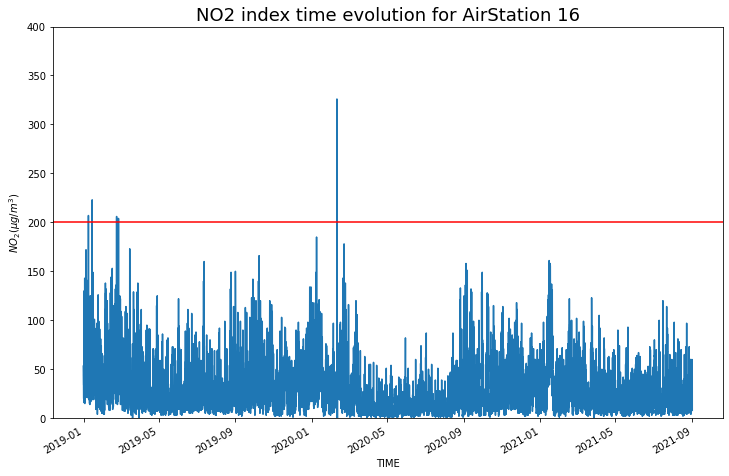

In [29]:

# Plotting  N02 index evolution for POC (station16)
plot = poc_16['NO2_index'].plot(figsize=(12, 8))
plt.ylim(0,400)
plt.ylabel("$NO_2 (µg/m^3)$", fontsize=10)
plt.xlabel("TIME", fontsize=10)
plt.title ("NO2 index time evolution for AirStation 16", fontsize=18)
plt.axhline(y=200, c='r');


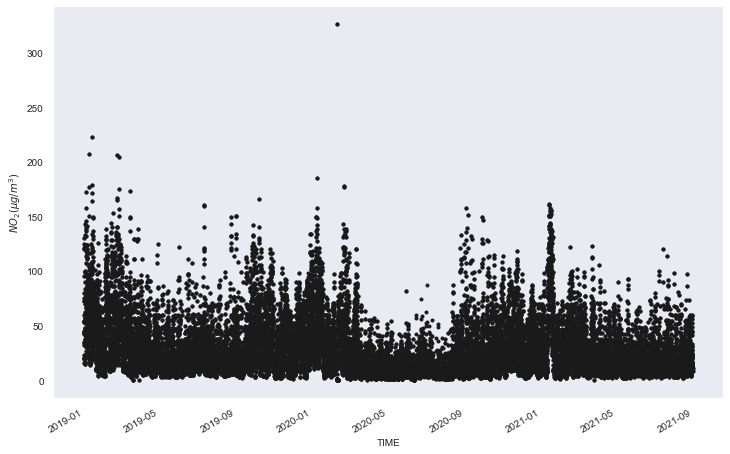

In [62]:
poc_16["NO2_index"].plot(style='.k', figsize=(12,8))
plt.tick_params(labelsize=10)
plt.ylabel("$NO_2 (µg/m^3)$", fontsize=10)
plt.xlabel("TIME", fontsize=10)
plt.grid();

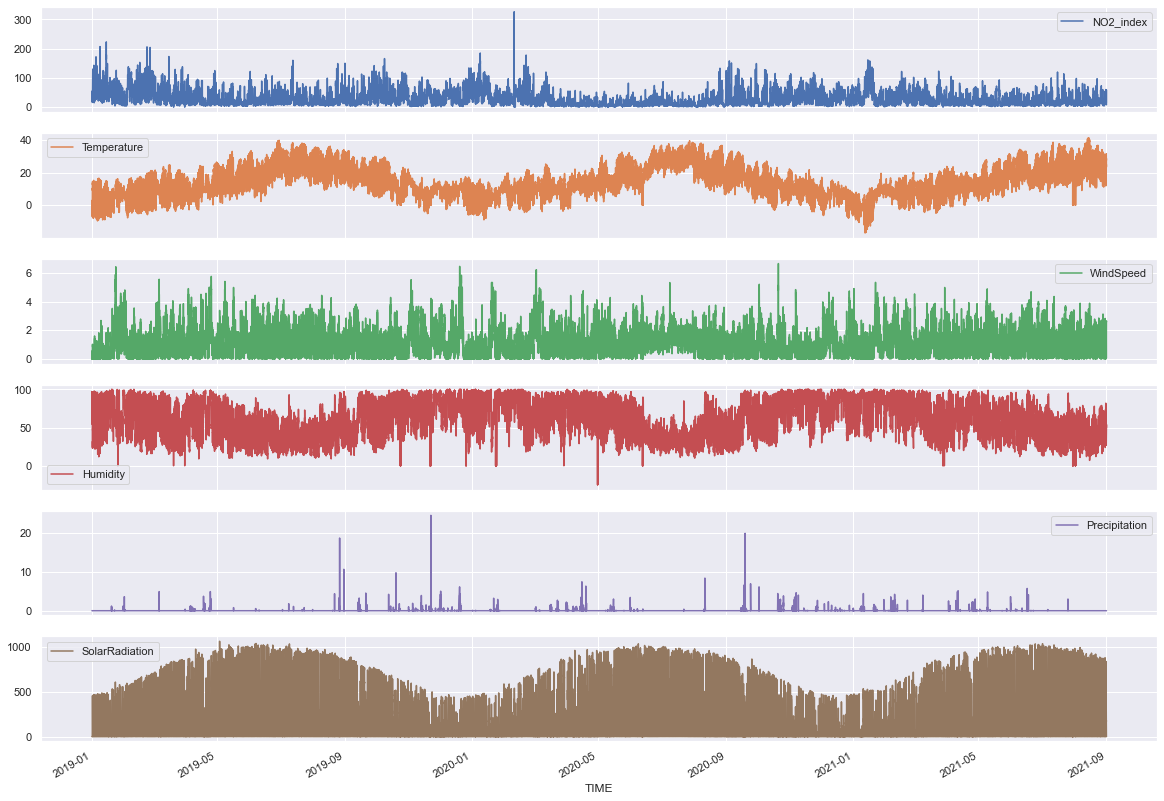

In [63]:
poc_16_a = poc_16[["NO2_index", "Temperature", "WindSpeed", "Humidity", "Precipitation", "SolarRadiation"]]
poc_16_a.plot(subplots=True, figsize=(20,15));

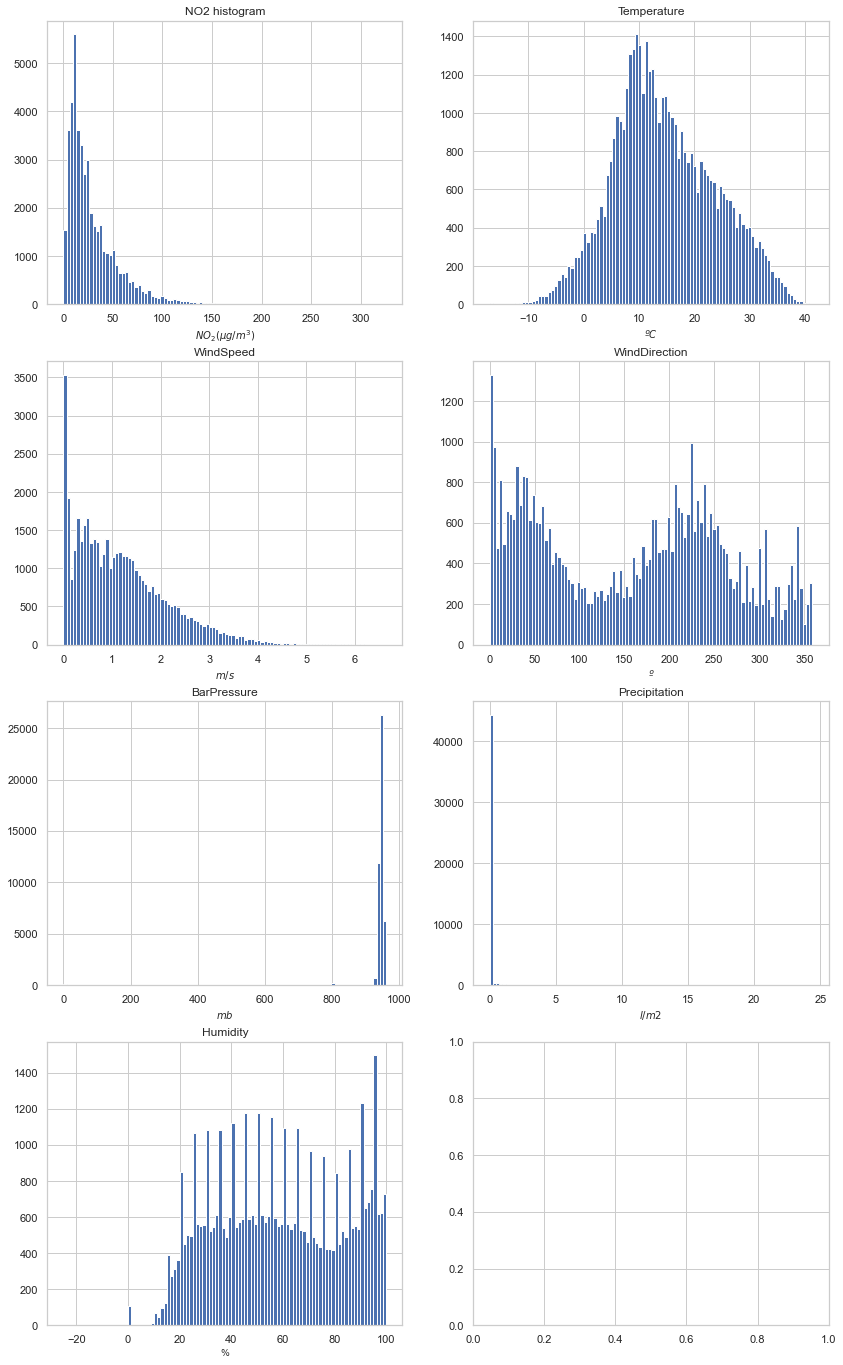

In [99]:
#N02 index vs Weather parameters
x1=poc_16["NO2_index"]
y1=poc_16["Temperature"]
y2=poc_16["WindSpeed"]
y3=poc_16["WindDirection"]
y4=poc_16["BarPressure"]
y5=poc_16["Precipitation"]
y6=poc_16["Humidity"]

fig, ax = plt.subplots(4,2)
fig.set_size_inches(14,24)
ax[0, 0].hist(x1, bins=100)
ax[0, 0].set_title("NO2 histogram")
ax[0, 0].set_xlabel("$NO_2 (µg/m^3)$", fontsize=10)

ax[0, 1].hist(y1, bins=100)
ax[0, 1].set_title("Temperature")
ax[0, 1].set_xlabel("$ºC$", fontsize=10)

ax[1, 0].hist(y2, bins=100)
ax[1, 0].set_title("WindSpeed")
ax[1, 0].set_xlabel("$m/s$", fontsize=10)

ax[1, 1].hist(y3, bins=100)
ax[1, 1].set_title("WindDirection")
ax[1, 1].set_xlabel("$º$", fontsize=10)

ax[2, 0].hist(y4, bins=100)
ax[2, 0].set_title("BarPressure")
ax[2, 0].set_xlabel("$mb$", fontsize=10)

ax[2, 1].hist(y5, bins=100)
ax[2, 1].set_title("Precipitation")
ax[2, 1].set_xlabel("$l/m2$", fontsize=10)

ax[3, 0].hist(y6, bins=100)
ax[3, 0].set_title("Humidity")
ax[3, 0].set_xlabel("%", fontsize=10);

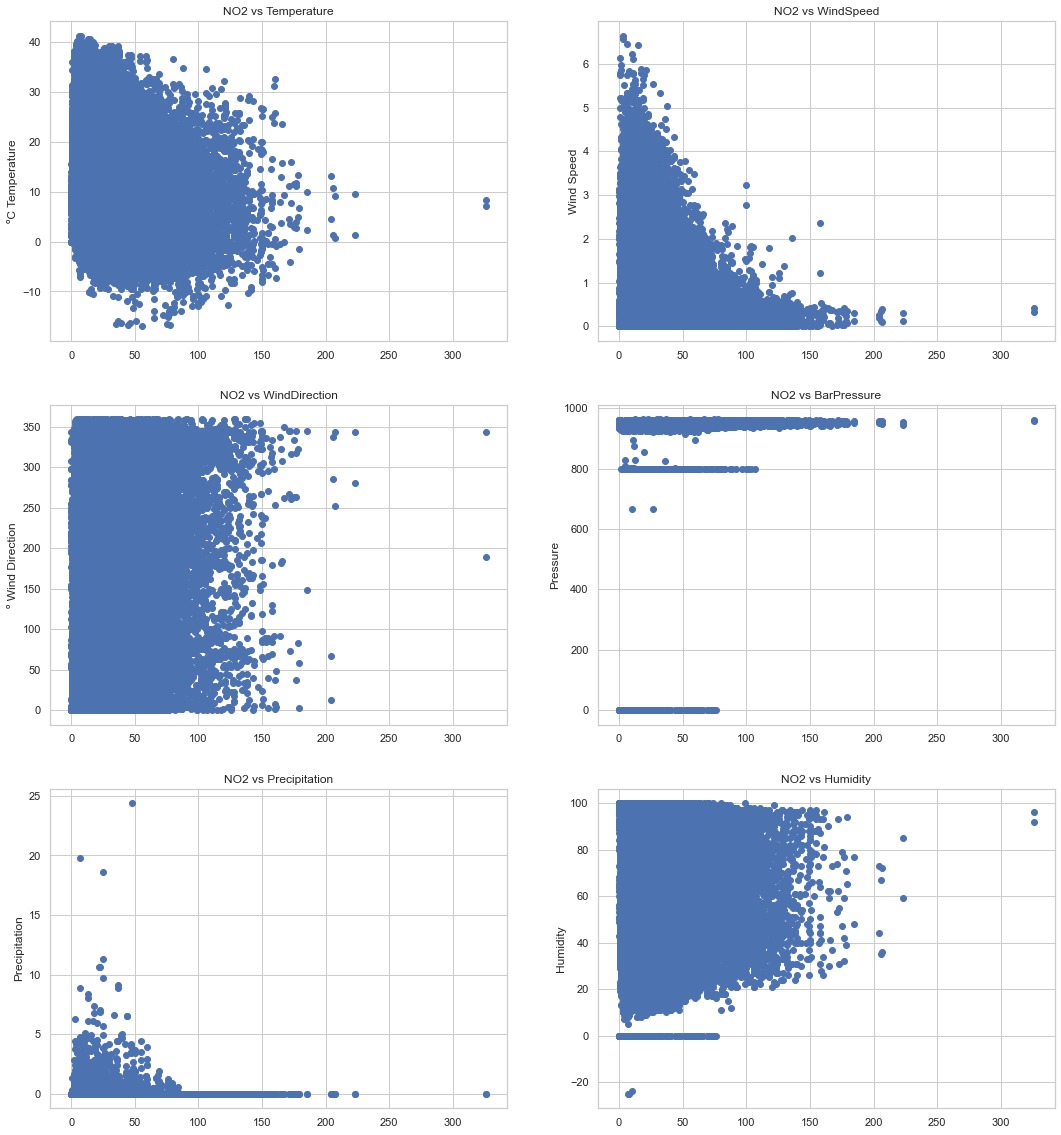

In [97]:
#N02 index vs Weather parameters
x1=poc_16["NO2_index"]
y1=poc_16["Temperature"]
y2=poc_16["WindSpeed"]
y3=poc_16["WindDirection"]
y4=poc_16["BarPressure"]
y5=poc_16["Precipitation"]
y6=poc_16["Humidity"]

fig, ax = plt.subplots(3,2)
fig.set_size_inches(18,20)
ax[0, 0].scatter(x=x1, y=y1)
ax[0, 0].set_title("NO2 vs Temperature")
ax[0, 0].set_ylabel("ºC Temperature")
ax[0, 1].scatter(x=x1, y=y2)
ax[0, 1].set_title("NO2 vs WindSpeed")
ax[0, 1].set_ylabel("Wind Speed - m/s")
ax[1, 0].scatter(x=x1, y=y3)
ax[1, 0].set_title("NO2 vs WindDirection")
ax[1, 0].set_ylabel("º Wind Direction")
ax[1, 1].scatter(x=x1, y=y4)
ax[1, 1].set_title("NO2 vs BarPressure")
ax[1, 1].set_ylabel("Pressure - mb")
ax[2, 0].scatter(x=x1, y=y5)
ax[2, 0].set_title("NO2 vs Precipitation")
ax[2, 0].set_ylabel("Precipitation - l/m2")
ax[2, 1].scatter(x=x1, y=y6)
ax[2, 1].set_title("NO2 vs Humidity")
ax[2, 1].set_ylabel("Humidity - %");

<ipython-input-68-e13a33c0e94d>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticks(), fontsize=13)
<ipython-input-68-e13a33c0e94d>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels(axes[0].get_yticks(), fontsize=13)
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


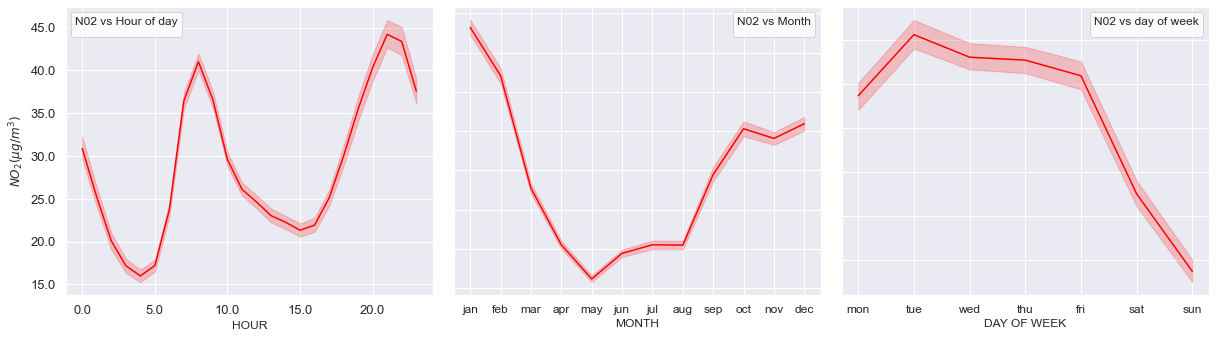

In [68]:
# Overview of NO2 concentrations by hour, month and day of week
fig,axes = plt.subplots(1, 3,sharex=False, figsize=(16,4)) #creating subplots, side by side
fig.tight_layout(pad=-1) # makeing plots get closer
sbn.set_style('whitegrid')

# N02 vs hour
axes[0] = sbn.lineplot(ax=axes[0],data=poc_16,
                            x=poc_16['TIME'].dt.hour,
                            y="NO2_index",
                            color='red',
                            linewidth=1.5,
                            palette="hls")
axes[0].set_xticklabels(axes[0].get_xticks(), fontsize=13)
axes[0].set_yticklabels(axes[0].get_yticks(), fontsize=13)
axes[0].set_xlabel('HOUR', fontsize=12)
axes[0].set_ylabel("$NO_2 (µg/m^3)$", fontsize=12)
axes[0].legend().set_title('N02 vs Hour of day')

  # N02 vs month
month = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
axes[1] = sbn.lineplot(ax=axes[1],
                           data=poc_16,
                           x=poc_16['TIME'].dt.month,
                           y="NO2_index",
                           color='red',
                           linewidth=1.5,
                           palette="hls")
axes[1].set_xticks(np.arange(1, 13, 1))
axes[1].set_xticklabels(month, fontsize=12)
axes[1].set_yticklabels('')
axes[1].set_xlabel('MONTH', fontsize=12)
axes[1].set_ylabel("")
axes[1].legend().set_title('N02 vs Month')

 # N02 vs day of week
week = ["mon", "tue", "wed", "thu", "fri", "sat", "sun"]
axes[2] = sbn.lineplot(ax=axes[2],
                           data=poc_16,
                           x=poc_16['TIME'].dt.dayofweek,
                           y="NO2_index",
                           color='red',
                           linewidth=1.5,
                           palette="hls")
axes[2].set_xticks(np.arange(0, 7, 1))
axes[2].set_xticklabels(week, fontsize=12)
axes[2].set_yticklabels('')
axes[2].set_xlabel('DAY OF WEEK', fontsize=12)
axes[2].set_ylabel('')
axes[2].legend().set_title('N02 vs day of week')

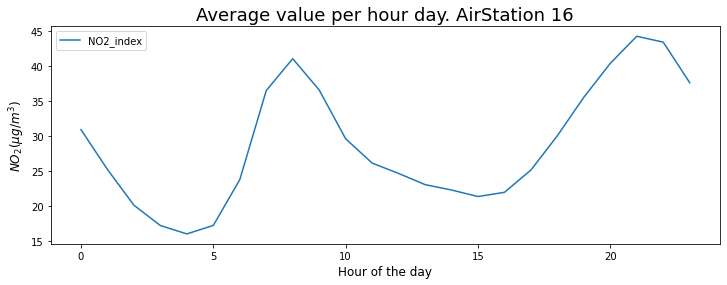

In [159]:
fig, axs = plt.subplots(figsize=(12, 4))

mean2019 = poc_16.loc["2019"]
mean2020 = poc_16.loc["2020"]
mean2021 = poc_16.loc["2021"]

poc_16.groupby(poc_16["TIME"].dt.hour)["NO2_index"].mean().plot(kind='line', rot=0, ax=axs)
#mean2019.groupby(mean2019["TIME"].dt.hour)["NO2_index"].mean().plot(kind='line', rot=0, ax=axs)
#mean2020.groupby(mean2020["TIME"].dt.hour)["NO2_index"].mean().plot(kind='line', rot=0, ax=axs)
#mean2021.groupby(mean2021["TIME"].dt.hour)["NO2_index"].mean().plot(kind='line', rot=0, ax=axs)
plt.xlabel("Hour of the day", fontsize=12);
plt.ylabel("$NO_2 (µg/m^3)$", fontsize=12);
plt.title("Average value per hour day. AirStation 16", fontsize=18);

plt.legend();


Overview:

A lag in a time-series data is how much one point is falling behind in time from another data point.

In a time-series data, data points are marked over time at varying degrees of intervals.

To analyse and find out if a time-series data follows any pattern, a lag plot can be employed.

A lag plot is drawn by representing the time series data in x-axis and the lag of the time series data point in y axis. For a data point, if the order of the lag is one, the lag is the previous data point. If the lag is two, the lag is data point before two data points in time.

By drawing a lag plot, patterns like randomness, trends and seasonality can be searched for.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


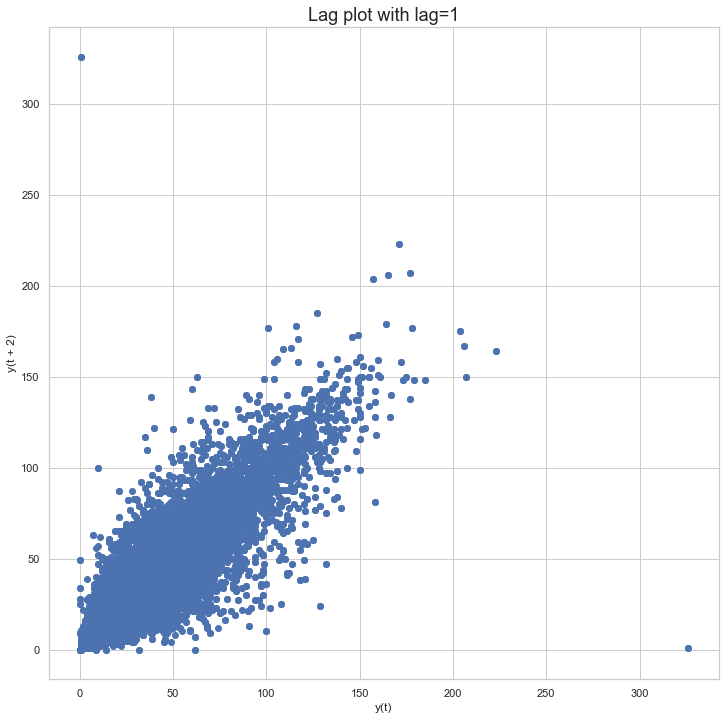

In [111]:
#visualizing the lag of the serie

from pandas.plotting import lag_plot
fig, axs = plt.subplots(figsize=(12, 12))
pd.plotting.lag_plot(poc_16["NO2_index"],lag=2);
plt.title("Lag plot with lag=1",fontsize=18)
plt.show(block=True)

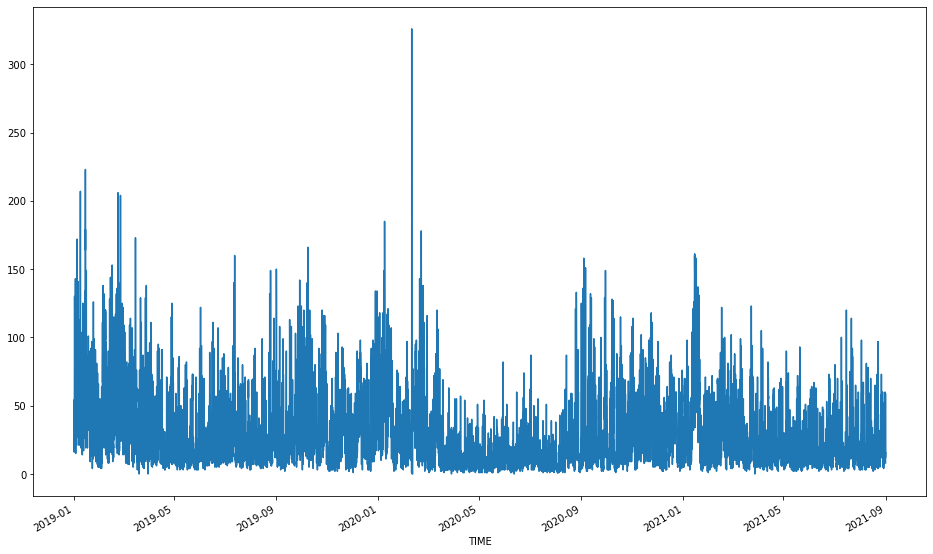

In [16]:
poc_16['NO2_index'].plot(figsize=(16, 10));

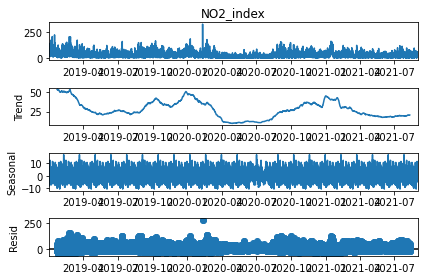

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
#poc_16['NO2_index'].plot(figsize=(16, 10))

figsize=20,20
result=seasonal_decompose(poc_16["NO2_index"],model='additive',period=2000)
result.plot();

<AxesSubplot:>

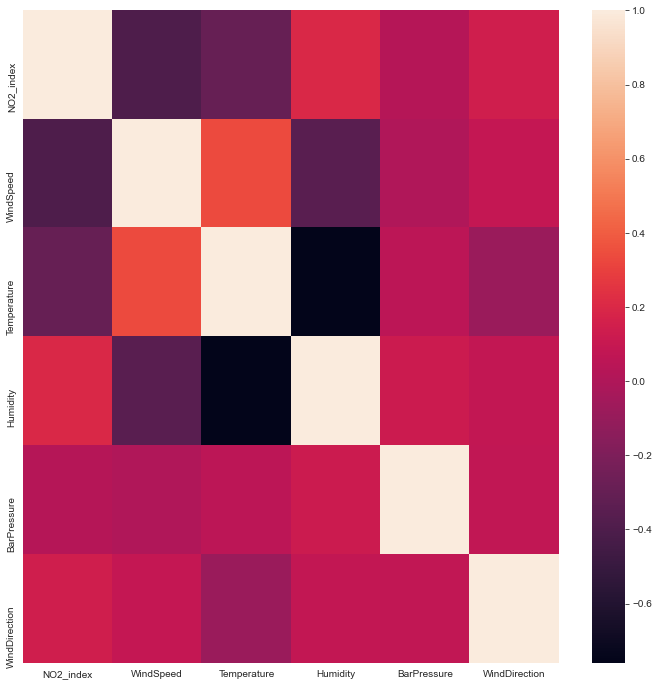

In [26]:
# Correlation matrix
poc_16_b = poc_16 [["NO2_index", "WindSpeed","Temperature", "Humidity", "BarPressure","WindDirection"]]

fig,axes = plt.subplots(figsize=(12,12))


corr = poc_16_b.corr()
sbn.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [32]:
poc_16t = poc_16[["TIME","AirStationId","WeatherStationId","NO2_index", "WindSpeed","WindDirection","Temperature", "BarPressure", "Humidity","Precipitation"]]
poc_16t.to_csv ("../data/processed/poc_16.csv")
